In [1]:
import os
import math

import matplotlib
import numpy as np
import sys
import scipy
import yaml

from sklearn.metrics import mean_squared_error

sys.path.append('../')
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from matplotlib import cm

from slow_reservoir.model import RNN, RNNSimple
from slow_reservoir.dataset.dynamic_state import State

%matplotlib inline

In [2]:
state_list = [
    State(mu=0.5, sigma=0.4),
    State(mu=0, sigma=0.2),
    State(mu=-0.5, sigma=0.1),
]

In [3]:
def make_signal(N, time_length, state_list, uncertainty=0.5):
    input_signals = np.zeros([N, time_length, 100])
    phi = np.linspace(-2, 2, 100)
    sigma_sq = 0.5
    target_list = np.zeros([N, 400])
    signal_mu_list = np.zeros((N, time_length))
    true_signal_list = np.zeros((N, time_length))
    
    for i in range(N):
        signal_input = np.zeros([time_length, 100])
        for t in range(time_length):
            true_signal = state_list[0]()
            true_signal_list[i, t] = true_signal
            # true_signal = state_list[2]()
            g = 2
            signal_sigma = np.sqrt(1 / g) * uncertainty
            signal_mu = np.random.normal(true_signal, signal_sigma)
            signal_mu_list[i, t] = signal_mu
            
            signal_base = g * 1 * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
            signal_input[t] = np.random.poisson(signal_base)
        
        input_signals[i] = signal_input
        # signal_mu_list.append(signal_mu)
        
    return input_signals, true_signal_list, signal_mu_list

In [4]:
config_path = '../slow_reservoir/trained_model/dynamic_state_random/20220423_2/20220423_2.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    

model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model = RNN(
    n_in=cfg['DATALOADER']['INPUT_NEURON'],
    n_out=1,
    n_hid=cfg['MODEL']['SIZE'],
    n_reservoir=cfg['MODEL']['RESERVOIR'],
    device=device,
    alpha_fast=cfg['MODEL']['ALPHA_FAST'],
    alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
    sigma_neu=cfg['MODEL']['SIGMA_NEU'],
).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state_random/{model_name}/epoch_400.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()



model_name:  20220423_2


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

In [5]:
sample_num = 1
input_signal, true_signal_list, signal_mu_list = make_signal(
    sample_num, 
    state_list=state_list,
    time_length=120, 
    uncertainty=0.5,
)

inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device) 

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))
             

# priorなしのモデルによる推論
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs, prior_list, reservoir_list = model(inputs, hidden, reservoir, 120)                                                     
neural_dynamics = hidden_list.cpu().detach().numpy()   
reservoir_dynamics = reservoir_list.cpu().detach().numpy()


In [6]:
def calc_bayesian_optimal(mu_l, sigma_l, mu_p, sigma_p):
    return mu_p * (sigma_l**2/(sigma_p**2+sigma_l**2)) + mu_l * (sigma_p**2/(sigma_p**2+sigma_l**2))

In [7]:
sigma_l = math.sqrt(1/2) * 0.5
bayesian_optimal = calc_bayesian_optimal(signal_mu_list[0], sigma_l, 0.5, 0.4)

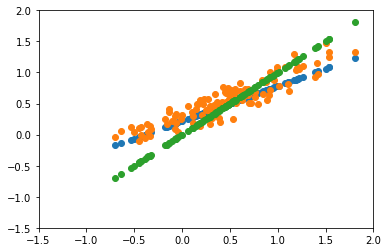

In [8]:
plt.scatter(
    signal_mu_list[0],
    bayesian_optimal,
)
plt.scatter(
    signal_mu_list[0],
    outputs.detach().numpy()[:, :, 0],
)
plt.scatter(
    signal_mu_list[0],
    signal_mu_list[0],
)
plt.xlim([-1.5, 2])
plt.ylim([-1.5, 2])
plt.show()

In [9]:
sample_num = 1
state_list = [
    State(mu=0, sigma=0.2),
]
input_signal, true_signal_list, signal_mu_list = make_signal(
    sample_num, 
    state_list=state_list,
    time_length=120, 
    uncertainty=0.5,
)

inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device) 

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))
             

# priorなしのモデルによる推論
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs, prior_list, reservoir_list = model(inputs, hidden, reservoir, 120)                                                     
neural_dynamics = hidden_list.cpu().detach().numpy()   
reservoir_dynamics = reservoir_list.cpu().detach().numpy()


In [10]:
# sigma_l = math.sqrt(1/3) * 0.5
bayesian_optimal = calc_bayesian_optimal(signal_mu_list[0], sigma_l, 0, 0.2)

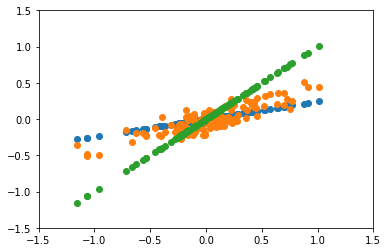

In [11]:
plt.scatter(
    signal_mu_list[0],
    bayesian_optimal,
)
plt.scatter(
    signal_mu_list[0],
    outputs.detach().numpy()[:, :, 0],
)
plt.scatter(
    signal_mu_list[0],
    signal_mu_list[0],
)
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.show()

In [12]:
sample_num = 1
state_list = [
    State(mu=-0.5, sigma=0.1),
]
input_signal, true_signal_list, signal_mu_list = make_signal(
    sample_num, 
    state_list=state_list,
    time_length=120, 
    uncertainty=0.5,
)

inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device) 

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))
             

# priorなしのモデルによる推論
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs, prior_list, reservoir_list = model(inputs, hidden, reservoir, 120)                                                     
neural_dynamics = hidden_list.cpu().detach().numpy()   
reservoir_dynamics = reservoir_list.cpu().detach().numpy()


In [13]:
# sigma_l = math.sqrt(1/3) * 0.5
bayesian_optimal = calc_bayesian_optimal(signal_mu_list[0], sigma_l, -0.5, 0.1)

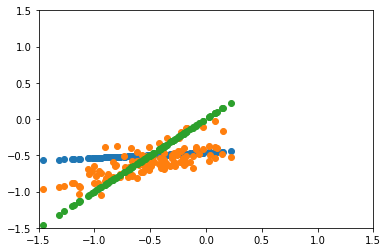

In [14]:
plt.scatter(
    signal_mu_list[0],
    bayesian_optimal,
)
plt.scatter(
    signal_mu_list[0],
    outputs.detach().numpy()[:, :, 0],
)
plt.scatter(
    signal_mu_list[0],
    signal_mu_list[0],
)
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.show()